# Analysing the xenograft data from Campbell et al (2019)
In this notebook we apply SCATrEx to the triple negative breast cancer mouse xenograft data set SA501, which is available [here](https://zenodo.org/record/2363826). We use the original copy number calls and assemble them in a given CNA tree that we use in SCATrEx. Running the notebook (except the data download) takes about 10 minutes on a common laptop.

Note: we recommend you to go through the [SCATrEx tutorial](https://github.com/cbg-ethz/SCATrEx/blob/master/notebooks/tutorial.ipynb) before running this notebook.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-setup" data-toc-modified-id="Data-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data setup</a></span><ul class="toc-item"><li><span><a href="#Download" data-toc-modified-id="Download-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download</a></span></li><li><span><a href="#Read-in-scDNA-data" data-toc-modified-id="Read-in-scDNA-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Read in scDNA data</a></span></li><li><span><a href="#Read-in-scRNA-data" data-toc-modified-id="Read-in-scRNA-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Read in scRNA data</a></span></li></ul></li><li><span><a href="#Annotate-the-scRNA-clusters" data-toc-modified-id="Annotate-the-scRNA-clusters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Annotate the scRNA clusters</a></span></li><li><span><a href="#Intersect-scDNA-and-scRNA-genes" data-toc-modified-id="Intersect-scDNA-and-scRNA-genes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Intersect scDNA and scRNA genes</a></span></li><li><span><a href="#Map-cells-to-clones-using-clonealign" data-toc-modified-id="Map-cells-to-clones-using-clonealign-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Map cells to clones using clonealign</a></span><ul class="toc-item"><li><span><a href="#Run-clonealign-and-confirm-assignments" data-toc-modified-id="Run-clonealign-and-confirm-assignments-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Run clonealign and confirm assignments</a></span></li><li><span><a href="#Annotate-clones" data-toc-modified-id="Annotate-clones-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Annotate clones</a></span></li><li><span><a href="#Compare-clusters-with-clones" data-toc-modified-id="Compare-clusters-with-clones-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Compare clusters with clones</a></span></li></ul></li><li><span><a href="#Augment-the-CNV-tree-using-SCATrEx" data-toc-modified-id="Augment-the-CNV-tree-using-SCATrEx-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Augment the CNV tree using SCATrEx</a></span><ul class="toc-item"><li><span><a href="#Run-SCATrEx" data-toc-modified-id="Run-SCATrEx-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Run SCATrEx</a></span></li><li><span><a href="#Annotate-nodes" data-toc-modified-id="Annotate-nodes-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Annotate nodes</a></span></li><li><span><a href="#Compare-clones-with-clonealign-assignments" data-toc-modified-id="Compare-clones-with-clonealign-assignments-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Compare clones with clonealign assignments</a></span></li><li><span><a href="#Compare-nodes-with-clusters" data-toc-modified-id="Compare-nodes-with-clusters-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Compare nodes with clusters</a></span></li></ul></li><li><span><a href="#Embedding-using-tree" data-toc-modified-id="Embedding-using-tree-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Embedding using tree</a></span></li><li><span><a href="#Using-a-better-CNV-tree" data-toc-modified-id="Using-a-better-CNV-tree-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Using a better CNV tree</a></span></li></ul></div>

In [1]:
import scatrex

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import scanpy as sc
import anndata
import pyranges
import gseapy as gp

## Data setup

### Download

In [2]:
#!wget https://zenodo.org/record/2363826/files/clonealign-processed-data.tar.gz
#!tar xvzf clonealign-processed-data.tar.gz

In [3]:
scdna_path = 'clonealign-processed-data/SA501/cnv'
scrna_path = 'clonealign-processed-data/SA501/10X/20171026_SA501X2XB00096/outs/filtered_gene_bc_matrices/hg19'

### Read in scDNA data

In [4]:
# Read scDNA clonal CNV profiles
cnvs = pd.read_csv(f'{scdna_path}/SA501X3F.integer_copy_number.csv')
clones = pd.read_csv(f'{scdna_path}/SA501X3F_PX0286_PX0287_2-lane.clones.csv')

/Users/pedrof/opt/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
gr_cnvs = pyranges.from_dict(cnvs.rename(columns={'start':'Start', 'end': 'End', 'chr': 'Chromosome'}).to_dict())

In [6]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "start_position", "end_position", "chromosome_name"],
    ).set_index("ensembl_gene_id")
annot = annot.reset_index()
annot = annot.rename(columns={'start_position':'Start', 'end_position': 'End', 'chromosome_name': 'Chromosome'})
gr_annotations = pyranges.from_dict(annot.to_dict())

In [7]:
gr_annotated_cnvs = gr_cnvs.join(gr_annotations).drop(like="_b").cluster().df\
            .drop_duplicates('ensembl_gene_id')\
            .reset_index(drop=True).drop(columns='Cluster')
n_genes = gr_annotated_cnvs.shape[0]

In [8]:
# Create a dictionary of chr:genes for plotting
chr_var_names = dict()
for chromosome in gr_annotated_cnvs['Chromosome'].unique():
    chr_var_names[chromosome] = gr_annotated_cnvs.query(f' Chromosome=="{chromosome}" ')['ensembl_gene_id'].values

In [9]:
# Get the CNV clone profiles by taking the mode across their cells
unique_clones = clones['clone'].unique()
clone_cnvs = dict()
for clone in unique_clones:
    clone_cnvs[clone] = gr_annotated_cnvs[
                            clones.query(f' clone=="{clone}" ')['sample_id']
                        ].mode(1)[0].values.astype(float)

In [10]:
# Create clonal tree from CNV clones according to Zahn et al (2017)
cnv_tree_dict = {
           'root': {'parent': '-1',   'cnv':2*np.ones(n_genes,), 'size': 0,  'label':'root'},
           'A':    {'parent': 'root', 'cnv':clone_cnvs['A'],     'size': 60,  'label':'A'},
           'B':    {'parent': 'root', 'cnv':clone_cnvs['B'],     'size': 30,  'label':'B'},
           'C':    {'parent': 'B',    'cnv':clone_cnvs['C'],     'size': 10,  'label':'C'},
           }

/Users/pedrof/opt/anaconda3/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'node' as categorical


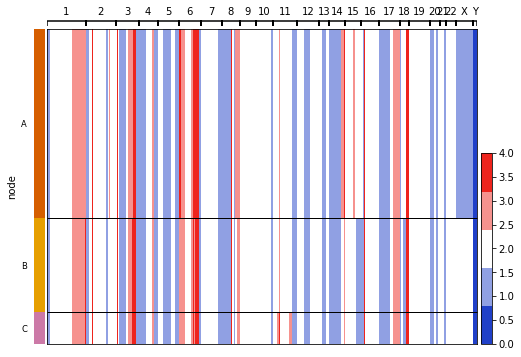

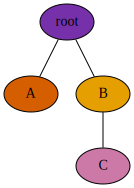

In [11]:
# Parse tree into ObservedTree object
observed_tree = scatrex.models.cna.ObservedTree()
observed_tree.read_tree_from_dict(cnv_tree_dict, input_params_key='cnv', input_parent_key='parent', root_parent='-1')
observed_tree.create_adata(var_names=gr_annotated_cnvs['ensembl_gene_id'].values)

observed_tree.plot_heatmap(var_names=chr_var_names)
observed_tree.plot_tree()

### Read in scRNA data

In [12]:
# Read scRNA count matrix and annotations
mat = io.mmread(f'{scrna_path}/matrix.mtx').toarray()
barcodes = pd.read_csv(f'{scrna_path}/barcodes.tsv', sep='\t', header=None)
genes = pd.read_csv(f'{scrna_path}/genes.tsv', sep='\t', header=None)

In [13]:
adata = anndata.AnnData(pd.DataFrame(mat.T, index=barcodes[0].values, columns=genes[1].values))
adata.var_names_make_unique()
adata.var['ensembl_gene_id'] = genes[0].values
adata.var['gene_id'] = genes[1].values

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [15]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [16]:
adata.raw = adata

In [17]:
# Further QC filtering
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

In [18]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata)
sc.tl.umap(adata)

/Users/pedrof/opt/anaconda3/envs/py36/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


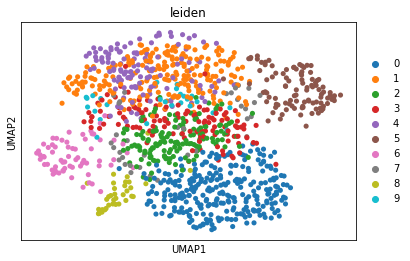

In [19]:
sc.pl.umap(adata, color='leiden')

In [20]:
# Get gene coordinates
df_annotations = gr_annotations.df.set_index('ensembl_gene_id')
df_exp_annotations = df_annotations.loc[df_annotations.index.intersection(adata.var['ensembl_gene_id'])]\
                        .reset_index().rename(columns={'index':'ensembl_gene_id'})
adata.var_names = adata.var['ensembl_gene_id'].values
adata = adata[:,df_exp_annotations['ensembl_gene_id']]

In [21]:
# Create a dictionary of chr:genes for plotting
chr_var_names = dict()
for chromosome in df_exp_annotations['Chromosome'].unique():
    chr_var_names[chromosome] = df_exp_annotations.query(f' Chromosome=="{chromosome}" ')\
                                    .sort_values('Start')['ensembl_gene_id'].values

In [22]:
# Put data in SCATrEx object
sca = scatrex.SCATrEx(model=scatrex.models.cna, verbose=True)
sca.add_data(adata)
sca.adata.var_names = sca.adata.var['ensembl_gene_id']

Smoothed gene expression is stored in `self.adata.layers["smoothed"]`


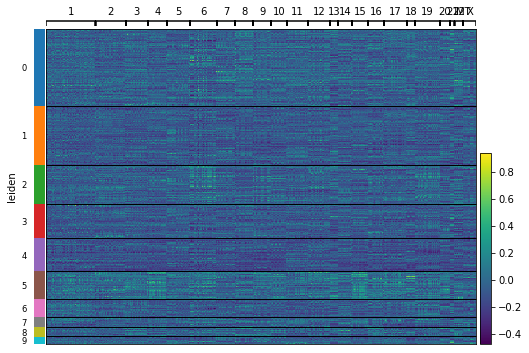

In [23]:
# Try to enhance CNV signal from gene expression profiles
sca.compute_smoothed_expression(var_names=chr_var_names, window_size=50, clip=3, copy=False)

sc.pl.heatmap(sca.adata, chr_var_names, groupby='leiden', cmap=None, show=True, use_raw=False, layer='smoothed')

## Annotate the scRNA clusters

Trying to set attribute `.uns` of view, copying.


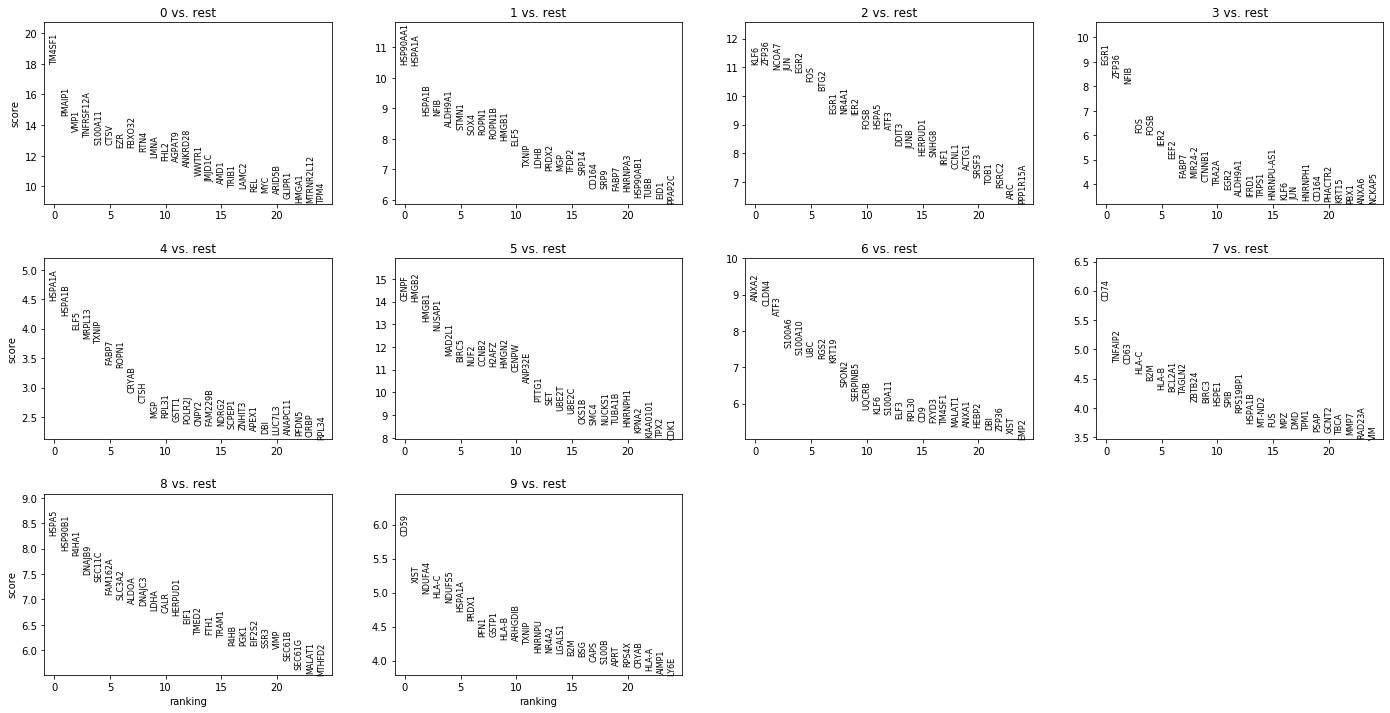

In [24]:
# Performing differential expression tests between the clones will reveal their phenotypic differences
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [25]:
# Using gseapy to annotate clusters according to their top DEGs
groups_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])[:25].to_dict(orient='list')
import gseapy as gp
enrichments = []
for group in groups_genes:
    enr = []
    if len(groups_genes[group]) > 0:
        enr = gp.enrichr(gene_list=groups_genes[group],
                     gene_sets=['MSigDB_Hallmark_2020', 'KEGG_2021_Human', 'Reactome_2016'],
                     organism='Human',
                     outdir='test/enrichr',
                     cutoff=0.01
                    ).results
        enr = enr[['Term','Adjusted P-value']].set_index('Term')
        enr = enr.loc[enr['Adjusted P-value'] < 0.01]
        enr = enr.drop('Adjusted P-value', axis=1).index.values
    enrichments.append(enr)
enrichments = dict(zip([group for group in groups_genes], enrichments))
cluster_annotations = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in enrichments.items() ]))

2021-08-10 19:32:42,555 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.01
2021-08-10 19:32:45,220 Warning: No enrich terms using library Reactome_2016 when cutoff = 0.01
2021-08-10 19:32:48,083 Warning: No enrich terms using library MSigDB_Hallmark_2020 when cutoff = 0.01
2021-08-10 19:33:13,746 Warning: No enrich terms using library MSigDB_Hallmark_2020 when cutoff = 0.01
2021-08-10 19:33:32,730 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.01
2021-08-10 19:33:35,517 Warning: No enrich terms using library Reactome_2016 when cutoff = 0.01


In [26]:
cluster_annotations.head(10)

,0,1,2,3,4,5,6,7,8,9
0,Epithelial Mesenchymal Transition,Antigen processing and presentation,TNF-alpha Signaling via NF-kB,TNF-alpha Signaling via NF-kB,Longevity regulating pathway,G2-M Checkpoint,Hypoxia,Interferon Gamma Response,mTORC1 Signaling,Interferon Gamma Response
1,NaN,Estrogen signaling pathway,Hypoxia,Hypoxia,Influenza Life Cycle Homo sapiens R-HSA-168255,E2F Targets,p53 Pathway,Interferon Alpha Response,Unfolded Protein Response,Interferon Alpha Response
2,NaN,Protein processing in endoplasmic reticulum,UV Response Up,Human T-cell leukemia virus 1 infection,Influenza Infection Homo sapiens R-HSA-168254,Mitotic Spindle,Estrogen Response Late,Antigen processing and presentation,Hypoxia,Antigen processing and presentation
3,NaN,Lipid and atherosclerosis,p53 Pathway,Amphetamine addiction,NaN,Myc Targets V1,Cholesterol Homeostasis,Viral myocarditis,Glycolysis,Allograft rejection
4,NaN,Protein export,Apoptosis,Kaposi sarcoma-associated herpesvirus infection,NaN,Cell cycle,TNF-alpha Signaling via NF-kB,Epstein-Barr virus infection,Myc Targets V1,Graft-versus-host disease
5,NaN,Spliceosome,mTORC1 Signaling,Colorectal cancer,NaN,Oocyte meiosis,NaN,Human T-cell leukemia virus 1 infection,Protein processing in endoplasmic reticulum,Type I diabetes mellitus
6,NaN,Necroptosis,Unfolded Protein Response,IL-17 signaling pathway,NaN,Progesterone-mediated oocyte maturation,NaN,Herpes simplex virus 1 infection,Protein export,Autoimmune thyroid disease
7,NaN,NOD-like receptor signaling pathway,Estrogen Response Late,Osteoclast differentiation,NaN,Cell Cycle Homo sapiens R-HSA-1640170,NaN,Cell adhesion molecules,Glycolysis / Gluconeogenesis,Viral myocarditis
8,NaN,Pyruvate metabolism,Inflammatory Response,Estrogen signaling pathway,NaN,"Cell Cycle, Mitotic Homo sapiens R-HSA-69278",NaN,Allograft rejection,HIF-1 signaling pathway,Epstein-Barr virus infection
9,NaN,Attenuation phase Homo sapiens R-HSA-3371568,TGF-beta Signaling,Fluid shear stress and atherosclerosis,NaN,M Phase Homo sapiens R-HSA-68886,NaN,Graft-versus-host disease,Phagosome,Human immunodeficiency virus 1 infection


## Intersect scDNA and scRNA genes

In [27]:
intersection = observed_tree.adata.var.index.intersection(adata.var['ensembl_gene_id'])
for node in observed_tree.tree_dict:
    observed_tree.tree_dict[node]['params'] = pd.DataFrame(observed_tree.tree_dict[node]['params'], 
                                                           index=observed_tree.adata.var_names).T[intersection]\
                                                            .values.ravel()
observed_tree.adata = observed_tree.adata[:, intersection]

In [28]:
raw_adata = adata.raw.to_adata()
raw_adata.var_names = raw_adata.var['ensembl_gene_id']
raw_adata = raw_adata[:,intersection]
raw_adata.var_names = raw_adata.var['gene_id']

observed_tree.adata.var['gene_id'] = raw_adata.var['gene_id']

Trying to set attribute `.var` of view, copying.


In [29]:
# Get gene coordinates
df_annotations = gr_annotations.df.set_index('ensembl_gene_id')
df_exp_annotations = df_annotations.loc[df_annotations.index.intersection(raw_adata.var['ensembl_gene_id'])]\
                        .reset_index().rename(columns={'index':'ensembl_gene_id'})

# Create a dictionary of chr:genes for plotting
chr_var_names = dict()
for chromosome in df_exp_annotations['Chromosome'].unique():
    chr_var_names[chromosome] = df_exp_annotations.query(f' Chromosome=="{chromosome}" ')\
                                    .sort_values('Start')['ensembl_gene_id'].values

... storing 'gene_id' as categorical


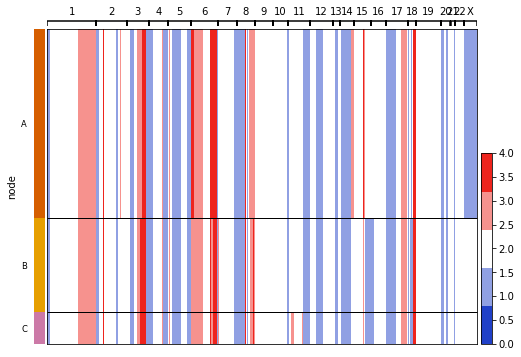

In [30]:
# We see that even after filtering, we still retain the regions that distinguish between the 3 clones
observed_tree.plot_heatmap(var_names=chr_var_names)

## Map cells to clones using clonealign

### Run clonealign and confirm assignments

In [31]:
# Create a new object for the inference
args = dict(num_global_noise_factors=4)
ca = scatrex.SCATrEx(model=scatrex.models.cna, verbose=True, model_args=args)
ca.add_data(raw_adata)
ca.set_observed_tree(observed_tree)
ca.normalize_data()
ca.project_data()
ca.adata.var_names = ca.adata.var['gene_id']

Normalized data are stored in `self.adata`
2-projected data are stored in `self.pca` and projection matrix in `self.pca_obj`


In [32]:
# Run clonealign
elbos = ca.learn_clonemap(n_iters=1000, filter_genes=True, step_size=0.01)

(4, 2260)
Diploid clones: root
Malignant clones: ['A', 'B', 'C']


Filtered scRNA data for clonemap shape: (1146, 500)
Adding data of shape (1146, 500) to NTSSB
[1 1 1 ... 1 1 1]
[1 1 1 1]
Recompiling objective!
Recompiling batch objective!
Created `self.gene_node_colormaps` with keys ['unobserved', 'observed', 'avg']


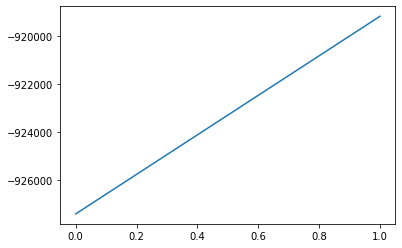

In [33]:
plt.plot(elbos)

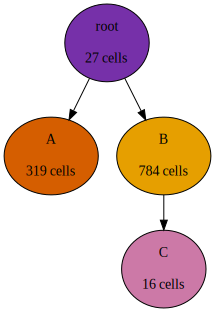

In [34]:
ca.plot_tree(counts=True)

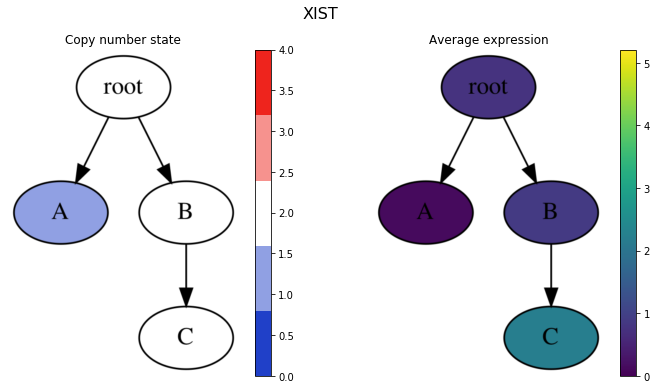

In [35]:
ca.adata.var_names = ca.adata.var['gene_id']
gene = 'XIST'
fig, ax_list = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,6))
ca.plot_tree(gene=gene, genemode='observed', title='Copy number state', cbtitle='', ax=ax_list[0])
ca.plot_tree(gene=gene, genemode='avg', title='Average expression', cbtitle='', ax=ax_list[1])
plt.suptitle(gene, fontsize=16)
plt.show()

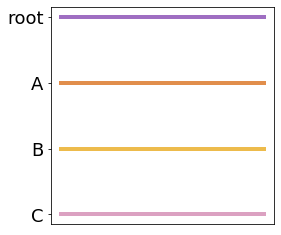

In [36]:
ca.plot_unobserved_parameters(estimated=True)

In [37]:
# cnv_levels = np.unique(observed_tree.adata.X)
# exp_levels = []
# for cnv in cnv_levels:
#     gene_avg = []
#     for gene in range(ca.adata.X.shape[1]):
#         cells = np.where(ca.adata.layers['clonemap_cnvs'][:,gene]==cnv)[0]
#         if len(cells) > 0:
#             gene_avg.append(np.mean(ca.adata.X[cells,gene]))
#     exp_levels.append(np.array(gene_avg))
    
# max_level = 4
# try:
#     max_level_pos = np.where(cnv_levels==max_level)[0][0]
# except IndexError:
#     print(f"{max_level} not present in {cnv_levels}.")
#     max_level_pos = np.argmax(cnv_levels)
# exp_levels[max_level_pos] = np.concatenate(exp_levels[max_level_pos:])
# exp_levels = exp_levels[:max_level_pos+1]
# cnv_levels = list(cnv_levels[:max_level_pos+1].astype(int))
# cnv_levels_labels = list(cnv_levels)
# cnv_levels_labels[max_level_pos] = f'{cnv_levels[max_level_pos]}+'

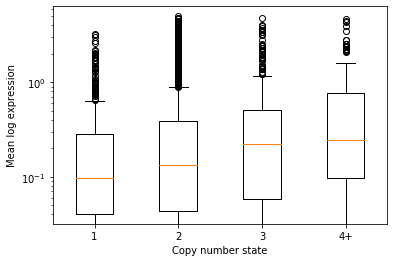

In [38]:
# The copy number state-specific expression distribution reflects good clonal assignments 
cnv_exp = ca.get_cnv_exp(max_level=4, method='clonemap')

cnv_levels = list(cnv_exp.keys())
cnv_levels_labels = [cnv_exp[l]['label'] for l in cnv_levels]
exp_levels = [cnv_exp[l]['exp'] for l in cnv_levels]

plt.boxplot(x=exp_levels)
plt.yscale('log')
plt.ylabel('Mean log expression')
plt.xlabel('Copy number state')
plt.xticks(cnv_levels, labels=cnv_levels_labels)
plt.show()

Smoothed gene expression is stored in `self.adata.layers["smoothed"]`


... storing 'node' as categorical
... storing 'obs_node' as categorical


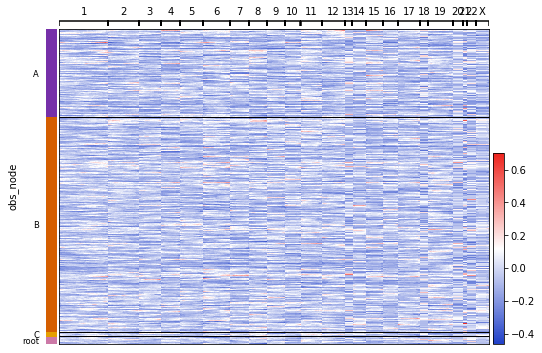

In [39]:
# Compare the real copy number signal with the smoothed gene expression
ca.adata.var_names = ca.adata.var['ensembl_gene_id']

ca.compute_smoothed_expression(var_names=chr_var_names, window_size=100, clip=3, copy=False)


sc.pl.heatmap(ca.adata, chr_var_names, groupby='obs_node', cmap=scatrex.plotting.constants.CNV_CMAP, 
                  show=True, use_raw=False, layer='smoothed')

ca.adata.var_names = ca.adata.var['gene_id']

In [40]:
ca.adata.uns['obs_node_colors'] = [observed_tree.tree_dict[node]['color'] for node in np.unique(ca.adata.obs['obs_node'])]

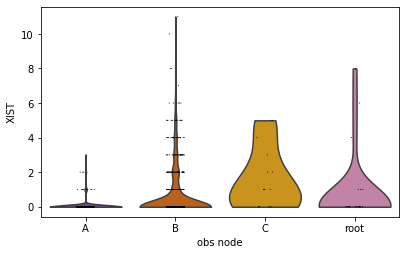

In [41]:
# The underexpression of inactive-chrX-specific-transcript XIST in clone A confirms that the active copy was retained
# sca.adata.uns['obs_node_colors'] = [observed_tree.tree_dict[node]['color'] for node in np.unique(sca.adata.obs['obs_node'])]
sc.pl.violin(ca.adata, ['XIST'], groupby='obs_node', raw=False)

### Annotate clones

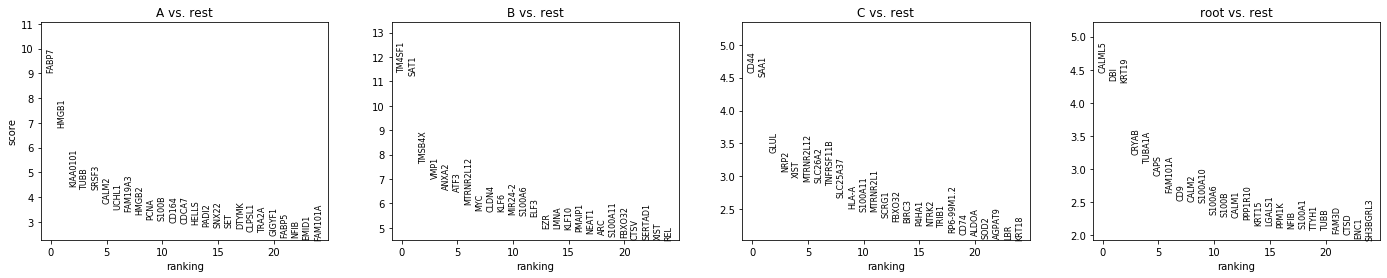

In [42]:
# Performing differential expression tests between the clones will reveal their phenotypic differences
sc.tl.rank_genes_groups(ca.adata, 'obs_node', method='wilcoxon')
sc.pl.rank_genes_groups(ca.adata, n_genes=25, sharey=False)

In [43]:
# Using gseapy to annotate clusters according to their top DEGs
groups_genes = pd.DataFrame(ca.adata.uns['rank_genes_groups']['names'])[:25].to_dict(orient='list')
enrichments = []
for group in groups_genes:
    enr = []
    if len(groups_genes[group]) > 0:
        enr = gp.enrichr(gene_list=groups_genes[group],
                     gene_sets=['MSigDB_Hallmark_2020', 'KEGG_2021_Human', 'Reactome_2016'],
                     organism='Human',
                     outdir='test/enrichr',
                     cutoff=0.01
                    ).results
        enr = enr[['Term','Adjusted P-value']].set_index('Term')
        enr = enr.loc[enr['Adjusted P-value'] < 0.01]
        enr = enr.drop('Adjusted P-value', axis=1).index.values
    enrichments.append(enr)
enrichments = dict(zip([group for group in groups_genes], enrichments))
clone_annotations = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in enrichments.items() ]))

2021-08-10 19:35:34,386 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.01
2021-08-10 19:35:42,581 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.01
2021-08-10 19:35:45,348 Warning: No enrich terms using library Reactome_2016 when cutoff = 0.01
2021-08-10 19:35:50,565 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.01
2021-08-10 19:35:53,228 Warning: No enrich terms using library Reactome_2016 when cutoff = 0.01
2021-08-10 19:35:55,784 Warning: No enrich terms using library MSigDB_Hallmark_2020 when cutoff = 0.01
2021-08-10 19:36:01,115 Warning: No enrich terms using library Reactome_2016 when cutoff = 0.01


In [44]:
clone_annotations.head(10)

,A,B,C,root
0,E2F Targets,TNF-alpha Signaling via NF-kB,Apoptosis,Estrogen signaling pathway
1,Myc Targets V1,Apoptosis,TNF-alpha Signaling via NF-kB,Phototransduction
2,Activation of DNA fragmentation factor Homo sa...,Estrogen Response Early,Fatty Acid Metabolism,Parkinson disease
3,Apoptosis induced DNA fragmentation Homo sapie...,NaN,Estrogen Response Early,Tuberculosis
4,DEx/H-box helicases activate type I IFN and in...,NaN,Interferon Gamma Response,Long-term potentiation
5,Advanced glycosylation endproduct receptor sig...,NaN,Glycolysis,Alzheimer disease
6,Hormone-sensitive lipase (HSL)-mediated triacy...,NaN,NaN,Amphetamine addiction
7,RIP-mediated NFkB activation via ZBP1 Homo sap...,NaN,NaN,Renin secretion
8,TRAF6 mediated NF-kB activation Homo sapiens R...,NaN,NaN,Glioma
9,ZBP1(DAI) mediated induction of type I IFNs Ho...,NaN,NaN,Pertussis


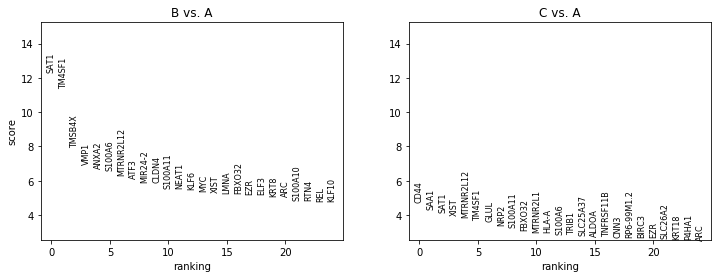

In [45]:
# Comparing to A reveals the underexpression of MHC class II proteins in that clone, as reported by clonealign
sc.tl.rank_genes_groups(ca.adata, 'obs_node', groups=['B', 'C'], reference='A', method='wilcoxon')
sc.pl.rank_genes_groups(ca.adata, groups=['B', 'C'], n_genes=25)

In [46]:
# Using gseapy to annotate clusters according to their top DEGs
groups_genes = pd.DataFrame(ca.adata.uns['rank_genes_groups']['names'])[:25].to_dict(orient='list')
enrichments = []
for group in groups_genes:
    enr = []
    if len(groups_genes[group]) > 0:
        enr = gp.enrichr(gene_list=groups_genes[group],
                     gene_sets=['MSigDB_Hallmark_2020', 'KEGG_2021_Human', 'Reactome_2016'],
                     organism='Human',
                     outdir='test/enrichr',
                     cutoff=0.01
                    ).results
        enr = enr[['Term','Adjusted P-value']].set_index('Term')
        enr = enr.loc[enr['Adjusted P-value'] < 0.01]
        enr = enr.drop('Adjusted P-value', axis=1).index.values
    enrichments.append(enr)
enrichments = dict(zip([group for group in groups_genes], enrichments))
clone_annotations = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in enrichments.items() ]))

2021-08-10 19:36:07,563 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.01
2021-08-10 19:36:15,549 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.01
2021-08-10 19:36:18,221 Warning: No enrich terms using library Reactome_2016 when cutoff = 0.01


In [47]:
clone_annotations.head(10)

,B,C
0,TNF-alpha Signaling via NF-kB,Apoptosis
1,p53 Pathway,TNF-alpha Signaling via NF-kB
2,Estrogen Response Early,Fatty Acid Metabolism
3,Apoptosis,Estrogen Response Early
4,Hypoxia,Epithelial Mesenchymal Transition
5,Dissolution of Fibrin Clot Homo sapiens R-HSA-...,Glycolysis


### Compare clusters with clones

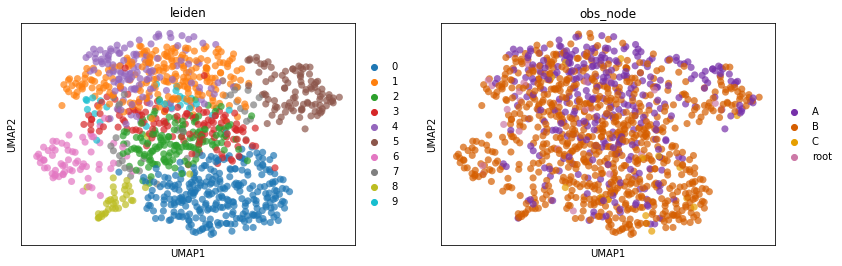

In [48]:
# Plot UMAP colored by clone assignments
sc.pl.umap(ca.adata, color=['leiden', 'obs_node'], s=200, alpha=0.7)

In [49]:
# Measure accordance of clonealign and unsupervised clustering with a confusion matrix
pd.crosstab(ca.adata.obs['leiden'], ca.adata.obs['obs_node'])

obs_node,A,B,C,root
leiden,,,,
0,41,228,9,1
1,97,108,2,8
2,31,109,0,2
3,39,79,2,5
4,45,72,1,3
5,45,53,1,2
6,2,61,0,2
7,11,24,0,1
8,7,26,1,1


In [50]:
# The low adjusted rand score quantitatively reflects this inconsistency between the two summaries
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(ca.adata.obs['leiden'], ca.adata.obs['obs_node'])

0.022610215718108957

## Augment the CNV tree using SCATrEx
The clonealign and the unsupervised clustering results are quite different: the confusion matrix indicates that each clone has cells in multiple different clusters, and vice-versa. Differential expression followed by pathway analyses on both groupings are not clearly consistent either. To reconcile the two approaches, we will use SCATrEx, which will jointly assign cells to clones and find new clusters constrained by the clonal tree. Limiting clusters to belong to clones is the most biologically meaningful approach, as the genotypes define a cell's identity -- and SCATrEx exploits that.

### Run SCATrEx

In [51]:
adata.var_names = adata.var['ensembl_gene_id']

In [52]:
raw_adata.var_names = raw_adata.var['ensembl_gene_id']

In [53]:
adata_copy = adata.copy()

In [54]:
sc.pp.highly_variable_genes(adata_copy, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=2000)

In [55]:
# adata_copy = adata_copy[:, adata_copy.var.highly_variable]

In [56]:
from copy import deepcopy
new_observed = deepcopy(observed_tree)
intersection = new_observed.adata.var.index.intersection(adata_copy.var['ensembl_gene_id'])
for node in new_observed.tree_dict:
    new_observed.tree_dict[node]['params'] = pd.DataFrame(new_observed.tree_dict[node]['params'], 
                                                           index=new_observed.adata.var_names).T[intersection]\
                                                            .values.ravel()
new_observed.adata = new_observed.adata[:, intersection]

new_raw_adata = raw_adata.copy()
new_raw_adata = new_raw_adata[:,intersection]

In [57]:
new_raw_adata.var_names = new_raw_adata.var['gene_id']

In [58]:
new_observed.adata.var_names = new_raw_adata.var['gene_id']

In [59]:
theta = 50
args = dict(global_noise_factors_precisions_shape=theta, num_global_noise_factors=4, 
            unobserved_factors_kernel_concentration=1/theta, unobserved_factors_root_kernel=1/theta)
sca = scatrex.SCATrEx(model=scatrex.models.cna, verbose=True, model_args=args)
sca.add_data(new_raw_adata)
sca.set_observed_tree(new_observed)
sca.normalize_data()
sca.project_data()

Normalized data are stored in `self.adata`
2-projected data are stored in `self.pca` and projection matrix in `self.pca_obj`


In [62]:
search_kwargs = {'n_iters': 200, 'n_iters_elbo': 2000,
                'moves':        ['add', 'merge', 'pivot_reattach', 'swap', 'subtree_reattach', 'push_subtree', 'perturb_node', 'reset_globals'],
                'move_weights': [1,         3,         1,            1,        .5,                  .5,              1,             .5],
                'local': True,
                'factor_delay': 0,
                'step_size': 0.01,
                'mb_size': 100,
                 'max_nodes':3,}
sca.learn_tree(reset=True, search_kwargs=search_kwargs)

Adding data of shape (1146, 2260) to NTSSB
Will search for the maximum marginal likelihood tree with the following moves: ['add', 'merge', 'pivot_reattach', 'swap', 'subtree_reattach', 'push_subtree', 'perturb_node', 'reset_globals']

[1 1 1 ... 1 1 1]
[ 1  1  1  1 -2 -2 -2 -2 -2 -2 -2 -2]
Recompiling objective!
Recompiling batch objective!
[1 1 1 ... 1 1 1]
[ 1  1  1  1 -2 -2 -2 -2 -2 -2 -2 -2]


  0%|          | 0/1 [00:00<?, ?it/s]

[1 1 1 ... 1 1 1]
[ 1  1  1  1 -2 -2 -2 -2 -2 -2 -2 -2]
Recompiling objective!
Recompiling batch objective!
*Move (full) accepted. (-6187462.0 -> -6019009.5)*
New best! -6019009.5


100%|██████████| 1/1 [00:49<00:00, 49.81s/it]


Getting the learned unobserved factors.
Created `self.gene_node_colormaps` with keys ['unobserved', 'observed', 'avg']


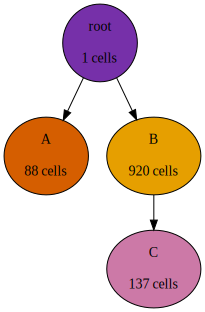

In [63]:
sca.plot_tree(counts=True)

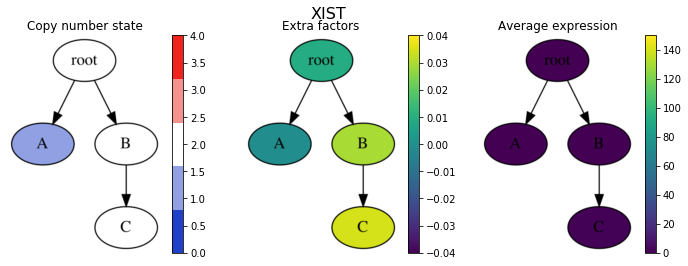

In [64]:
sca.adata.var_names = sca.adata.var['gene_id']
gene = 'XIST'
fig, ax_list = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,4))
sca.plot_tree(gene=gene, genemode='observed', title='Copy number state', cbtitle='', ax=ax_list[0])
sca.plot_tree(gene=gene, genemode='unobserved', title='Extra factors', cbtitle='', ax=ax_list[1])
sca.plot_tree(gene=gene, genemode='avg', title='Average expression', cbtitle='', ax=ax_list[2])
plt.suptitle(gene, fontsize=16)
plt.show()

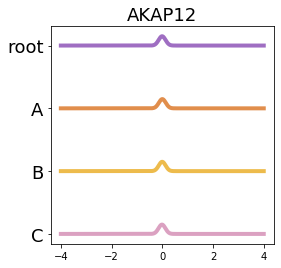

In [65]:
sca.plot_unobserved_parameters(estimated=True, gene='AKAP12', title='AKAP12', name='unobserved_factors', step=20)

In [ ]:
# cnv_levels = np.unique(new_observed.adata.X)
# exp_levels = []
# for cnv in cnv_levels:
#     gene_avg = []
#     for gene in range(sca.adata.X.shape[1]):
#         cells = np.where(sca.adata.layers['cnvs'][:,gene]==cnv)[0]
#         if len(cells) > 0:
#             gene_avg.append(np.mean(sca.adata.X[cells,gene]))
#     exp_levels.append(np.array(gene_avg))
    
# max_level = 4
# try:
#     max_level_pos = np.where(cnv_levels==max_level)[0][0]
# except IndexError:
#     print(f"{max_level} not present in {cnv_levels}.")
#     max_level_pos = np.argmax(cnv_levels)
# exp_levels[max_level_pos] = np.concatenate(exp_levels[max_level_pos:])
# exp_levels = exp_levels[:max_level_pos+1]
# cnv_levels = list(cnv_levels[:max_level_pos+1].astype(int))
# cnv_levels_labels = list(cnv_levels)
# cnv_levels_labels[max_level_pos] = f'{cnv_levels[max_level_pos]}+'

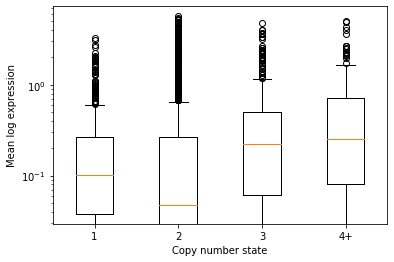

In [66]:
# The copy number state-specific expression distribution reflects good clonal assignments 
cnv_exp = sca.get_cnv_exp(max_level=4, method='scatrex')

cnv_levels = list(cnv_exp.keys())
cnv_levels_labels = [cnv_exp[l]['label'] for l in cnv_levels]
exp_levels = [cnv_exp[l]['exp'] for l in cnv_levels]

plt.boxplot(x=exp_levels)
plt.yscale('log')
plt.ylabel('Mean log expression')
plt.xlabel('Copy number state')
plt.xticks(cnv_levels, labels=cnv_levels_labels)
plt.show()

... storing 'node' as categorical
... storing 'obs_node' as categorical


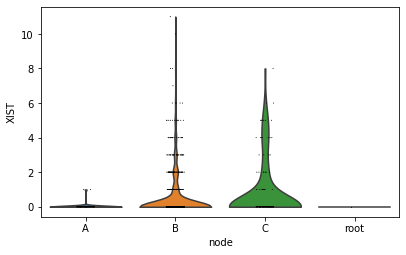

In [67]:
# The underexpression of inactive-chrX-specific-transcript XIST in clone A confirms that the active copy was retained
# sca.adata.uns['obs_node_colors'] = [observed_tree.tree_dict[node]['color'] for node in np.unique(sca.adata.obs['obs_node'])]
sc.pl.violin(sca.adata, ['XIST'], groupby='node', raw=False)

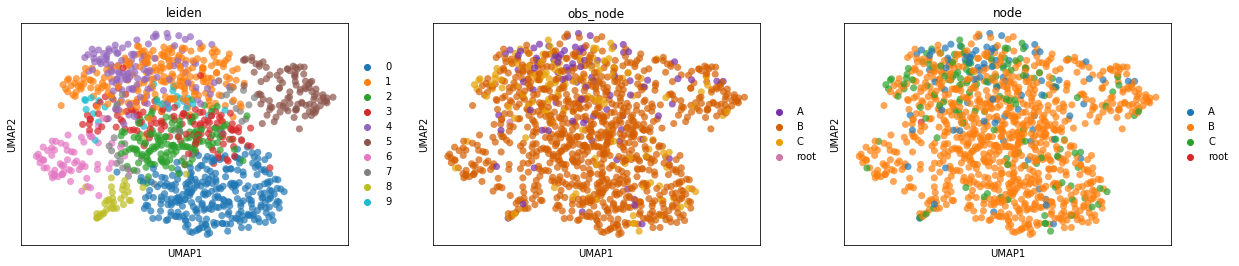

In [68]:
sc.pl.umap(sca.adata, color=['leiden', 'obs_node', 'node'], s=200, alpha=0.7)

In [70]:
# The unobserved factors clearly indicate that the MHC Class II proteins are under-expressed in clone A 
# even though the copy number of those genes are the same across all clones

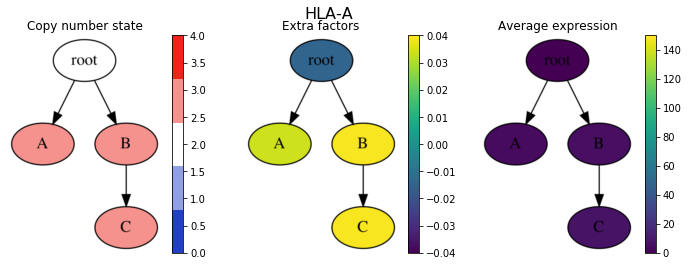

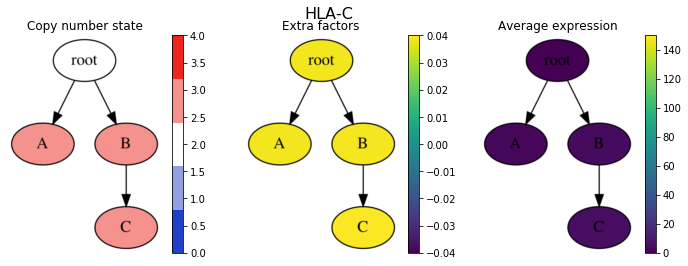

In [69]:
sca.adata.var_names = sca.adata.var['gene_id']

for gene in ['HLA-A', 'HLA-B', 'HLA-C', 'B2M']:
    if gene in sca.adata.var_names:
        fig, ax_list = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,4))
        sca.plot_tree(gene=gene, genemode='observed', title='Copy number state', cbtitle='', ax=ax_list[0])
        sca.plot_tree(gene=gene, genemode='unobserved', title='Extra factors', cbtitle='', ax=ax_list[1])
        sca.plot_tree(gene=gene, genemode='avg', title='Average expression', cbtitle='', ax=ax_list[2])
        plt.suptitle(gene, fontsize=16)
        plt.show()

### Annotate nodes

In [71]:
# Performing differential expression tests between the clones will reveal their phenotypic differences
sc.tl.rank_genes_groups(sca.adata, 'node', method='wilcoxon')
sc.pl.rank_genes_groups(sca.adata, n_genes=25, sharey=False)

ValueError: Could not calculate statistics for groups root since they only contain one sample.

In [ ]:
# Using gseapy to annotate clusters according to their top DEGs
groups_genes = pd.DataFrame(sca.adata.uns['rank_genes_groups']['names'])[:25].to_dict(orient='list')
enrichments = []
for group in groups_genes:
    enr = []
    if len(groups_genes[group]) > 0:
        enr = gp.enrichr(gene_list=groups_genes[group],
                     gene_sets=['MSigDB_Hallmark_2020', 'KEGG_2021_Human', 'Reactome_2016'],
                     organism='Human',
                     outdir='test/enrichr',
                     cutoff=0.01
                    ).results
        enr = enr[['Term','Adjusted P-value']].set_index('Term')
        enr = enr.loc[enr['Adjusted P-value'] < 0.01]
        enr = enr.drop('Adjusted P-value', axis=1).index.values
    enrichments.append(enr)
enrichments = dict(zip([group for group in groups_genes], enrichments))
node_annotations = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in enrichments.items() ]))

In [ ]:
node_annotations.head(10)

### Compare clones with clonealign assignments

In [72]:
# Measure accordance of SCATrEx and clonealign with a confusion matrix
pd.crosstab(ca.adata.obs['obs_node'], sca.adata.obs['obs_node'])

obs_node,A,B,C,root
obs_node,,,,
A,88,0,0,0
B,0,920,0,0
C,0,0,137,0
root,0,0,0,1


### Compare nodes with clusters

In [76]:
# Measure accordance of SCATrEx and unsupervised clustering with a confusion matrix
pd.crosstab(sca.adata.obs['leiden'], sca.adata.obs['node'])

node,A,B,C,root
leiden,,,,
0,8,247,24,0
1,36,130,49,0
2,4,132,6,0
3,13,100,12,0
4,16,86,19,0
5,7,86,8,0
6,1,61,3,0
7,1,28,7,0
8,2,28,5,0


In [74]:
# The low adjusted rand score quantitatively reflects this inconsistency between the two summaries
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(sca.adata.obs['leiden'], sca.adata.obs['obs_node'])

0.008350921436773429

## Embedding using tree
We compute a kNN graph of single cells using a combined distance in gene expression space and tree space. This graph is then used as input to the UMAP embedding.

## Using a better CNV tree
The CNV tree we used is limited as it doesn't make the most likely CNV profile of the most recent common ancestor of A and B explicit. To obtain such a tree, we resort to SCICoNE (Kuipers, Tuncel and Ferreira et al, 2021), which simultaneously learns clonal CNV profiles and their history from single-cell WGS data. This tree is available in the SCATrEx package: 